Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  print(data_folders)
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [5]:
def count_rows(dataset_name):
    with open(dataset_name,'rb') as f:
        return len(pickle.load(f))

[(dataset_name,count_rows(dataset_name)) for dataset_name in train_datasets+test_datasets]

[('notMNIST_large/A.pickle', 52909),
 ('notMNIST_large/B.pickle', 52911),
 ('notMNIST_large/C.pickle', 52912),
 ('notMNIST_large/D.pickle', 52911),
 ('notMNIST_large/E.pickle', 52912),
 ('notMNIST_large/F.pickle', 52912),
 ('notMNIST_large/G.pickle', 52912),
 ('notMNIST_large/H.pickle', 52912),
 ('notMNIST_large/I.pickle', 52912),
 ('notMNIST_large/J.pickle', 52911),
 ('notMNIST_small/A.pickle', 1872),
 ('notMNIST_small/B.pickle', 1873),
 ('notMNIST_small/C.pickle', 1873),
 ('notMNIST_small/D.pickle', 1873),
 ('notMNIST_small/E.pickle', 1873),
 ('notMNIST_small/F.pickle', 1872),
 ('notMNIST_small/G.pickle', 1872),
 ('notMNIST_small/H.pickle', 1872),
 ('notMNIST_small/I.pickle', 1872),
 ('notMNIST_small/J.pickle', 1872)]

In [6]:
from IPython import display
with open(format(train_datasets[0]),'rb') as f:
    dataset = pickle.load(f)

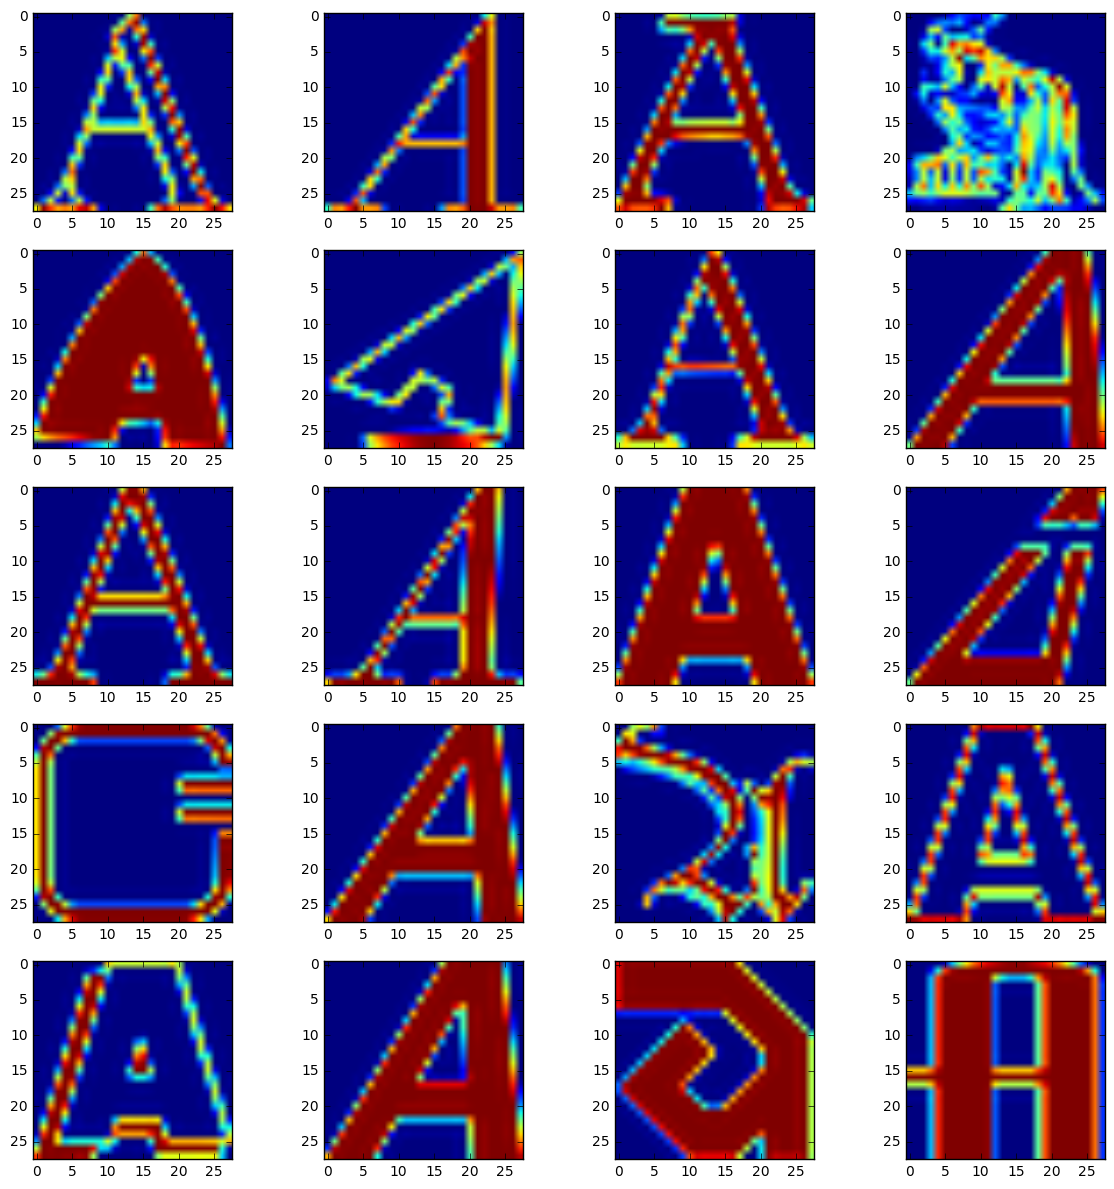

In [7]:
import random
rows,cols = 5,4
sample = random.sample(range(len(dataset)),rows*cols)
plt.figure(figsize=(12,12))
for i,j in enumerate(sample):
    plt.subplot(rows,cols,i+1)
    plt.imshow(dataset[j])
plt.tight_layout()

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [8]:
classes = 10
def append_dataset_and_labels(index,dataset_name):
    dataset = pickle.load(open(dataset_name,'rb'))
    labels = np.ones(dataset.shape[0],dtype=int)*index%classes
    return dataset,labels

dirty_train_dataset, dirty_train_labels = zip(*map(lambda (index,dataset_name): append_dataset_and_labels(index,dataset_name), enumerate(train_datasets)))
dirty_test_dataset, dirty_test_labels = zip(*map(lambda (index,dataset_name): append_dataset_and_labels(index,dataset_name), enumerate(test_datasets)))

In [9]:
dirty_train_dataset = np.vstack(dirty_train_dataset)
dirty_train_labels = np.hstack(dirty_train_labels)
dirty_test_dataset = np.vstack(dirty_test_dataset)
dirty_test_labels = np.hstack(dirty_test_labels)
print (dirty_train_dataset.shape, dirty_train_labels.shape)
print (dirty_test_dataset.shape, dirty_test_labels.shape)

(529114, 28, 28) (529114,)
(18724, 28, 28) (18724,)


In [10]:
import hashlib

# hash images
hash_train_dataset = [hashlib.sha1(x).digest() for x in dirty_train_dataset]
hash_test_dataset = [hashlib.sha1(x).digest() for x in dirty_test_dataset]

hash_train_dict = dict((h,i) for i,h in enumerate(hash_train_dataset))
hash_test_dict = dict((h,i) for i,h in enumerate(hash_test_dataset))

common_hashes = set(hash_train_dict).intersection(hash_test_dict)

for this_hash in common_hashes:
    del hash_test_dict[this_hash]
    
print("Deleted",len(common_hashes),"from test set ( now", len(hash_test_dict), ") due to conflict with train set (", len(hash_train_dict), ").")

Deleted 4583 from test set ( now 13649 ) due to conflict with train set ( 461946 ).


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
clean_train_dataset = dirty_train_dataset[hash_train_dict.values()]
clean_train_labels = dirty_train_labels[hash_train_dict.values()]
clean_test_dataset = dirty_test_dataset[hash_test_dict.values()]
clean_test_labels = dirty_test_labels[hash_test_dict.values()]

In [12]:
# Make the validation set the same size as the test set
test_size = valid_size = len(clean_test_labels)
# Generate a list of random permutation
random_idx = np.random.permutation(len(clean_train_dataset))
test_idx = np.random.permutation(test_size)
# Split the training dataset into train and validation set
valid_idx, train_idx = np.split(random_idx,[valid_size])

# Collect the dataset
train_dataset = clean_train_dataset[train_idx]
train_labels = clean_train_labels[train_idx]
valid_dataset = clean_train_dataset[valid_idx]
valid_labels = clean_train_labels[valid_idx]
test_dataset = clean_test_dataset[test_idx]
test_labels = clean_test_labels[test_idx]

print(train_dataset.shape,train_labels.shape)
print(valid_dataset.shape,valid_labels.shape)
print(test_dataset.shape,test_labels.shape)

(448297, 28, 28) (448297,)
(13649, 28, 28) (13649,)
(13649, 28, 28) (13649,)


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

(array([ 1398.,  1424.,  1380.,  1380.,  1390.,  1389.,  1407.,  1341.,
         1155.,  1385.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

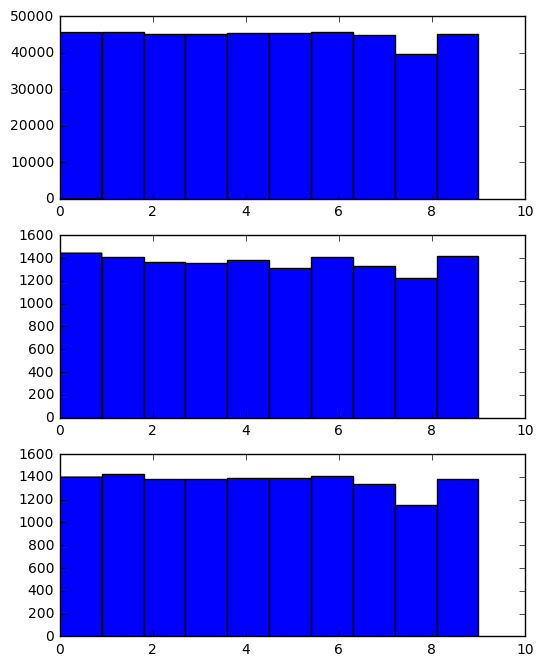

In [13]:
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
plt.hist(train_labels)
plt.subplot(3,1,2)
plt.hist(valid_labels)
plt.subplot(3,1,3)
plt.hist(test_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

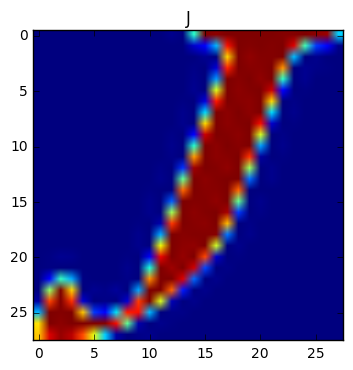

In [14]:
idx = 5000
plt.imshow(test_dataset[idx])
plt.title(chr(test_labels[idx]+65))

Finally, let's save the data for later reuse:

In [15]:
pickle_file = 'notMNIST.pickle'
override = True
if os.path.exists(pickle_file) and override is False:
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_dataset = save['train_dataset']
        train_labels = save['train_labels']
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']       
else:
    try:
        f = open(pickle_file, 'wb')
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size/1024/1024)

Compressed pickle size: 1426


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [26]:
def flatten(dataset):
    s = dataset.shape
    return dataset.reshape((s[0],s[1]*s[2]))

In [192]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
#     confusion_matrix(valid_pred,valid_labels)        

samples = [25,50,100,200,400,800,1600,3200,6400,12800]

models = {}
test_preds = {}
true_positive_rates = {}
train_dataset_flat = flatten(train_dataset)

def train_fit_test(model,samples):
    start = 0
    true_positive_rate = []
    for end in samples:
        model.fit(train_dataset_flat[start:end],train_labels[start:end])
        test_pred = np.rint(model.predict(flatten(test_dataset)))
        tp = accuracy_score(test_pred, test_labels)
        print (end, tp)
        true_positive_rate.append(tp)
        start = end

    return test_pred,true_positive_rate

In [195]:
label = 'LogisticRegression'
model = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, max_iter=1000, n_jobs=-1)
models[label] = model
test_preds[label], true_positive_rates[label] = train_fit_test(model,samples)

25 0.4968
50 0.4319
100 0.5818
200 0.7279
400 0.8077
800 0.8258
1600 0.8296
3200 0.8319
6400 0.8369
12800 0.8471


In [170]:
label = 'SGDClassifier'
model = linear_model.SGDClassifier()
models[label] = model
test_preds[label], true_positive_rates[label] = train_fit_test(model,samples)

25 0.3894
50 0.3662
100 0.5176
200 0.6298
400 0.7203
800 0.7577
1600 0.7925
3200 0.813
6400 0.8404
12800 0.845


In [181]:
label = 'RidgeClassifier'
model = linear_model.RidgeClassifier()
models[label] = model
test_preds[label], true_positive_rates[label] = train_fit_test(model,samples)

25 0.4993
50 0.4578
100 0.576
200 0.6741
400 0.6843
800 0.7083
1600 0.7295
3200 0.7648
6400 0.8076
12800 0.8367


In [186]:
from sklearn import tree
label = 'DecisionTreeClassifier'
model = tree.DecisionTreeClassifier()
models[label] = model
test_preds[label], true_positive_rates[label] = train_fit_test(model,samples)

25 0.2569
50 0.2069
100 0.3682
200 0.4641
400 0.5816
800 0.6396
1600 0.6734
3200 0.7232
6400 0.762
12800 0.7764


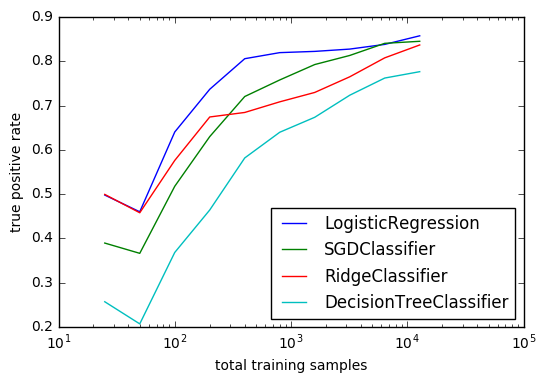

In [188]:

plt.figure()
for label,model in true_positive_rates.iteritems():
    plt.plot(samples,true_positive_rates[label],label=label)
plt.xlabel('total training samples')
plt.xscale('log')
plt.ylabel('true positive rate')
plt.legend(loc='bottom right')    

In [175]:
for label, true_positive_rate in true_positive_rates.iteritems():
    print (label, true_positive_rate)

LogisticRegression [0.49780000000000002, 0.46000000000000002, 0.64019999999999999, 0.73670000000000002, 0.80569999999999997, 0.81940000000000002, 0.82220000000000004, 0.82740000000000002, 0.83799999999999997, 0.85740000000000005]
SGDClassifier [0.38940000000000002, 0.36620000000000003, 0.51759999999999995, 0.62980000000000003, 0.72030000000000005, 0.75770000000000004, 0.79249999999999998, 0.81299999999999994, 0.84040000000000004, 0.84499999999999997]


In [180]:
import platform
print(platform.python_version())

2.7.6


In [68]:
incorrect = valid_pred!=valid_labels

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


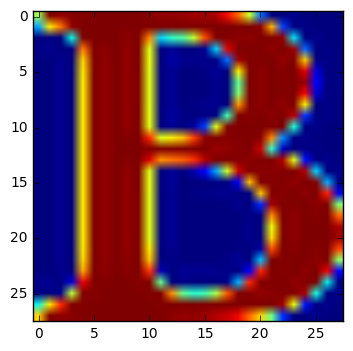

In [70]:
index
plt.imshow(valid_dataset[])

In [91]:
np.arange(10)**5+1000

array([ 1000,  1001,  1032,  1243,  2024,  4125,  8776, 17807, 33768, 60049])

In [ ]:
np.int